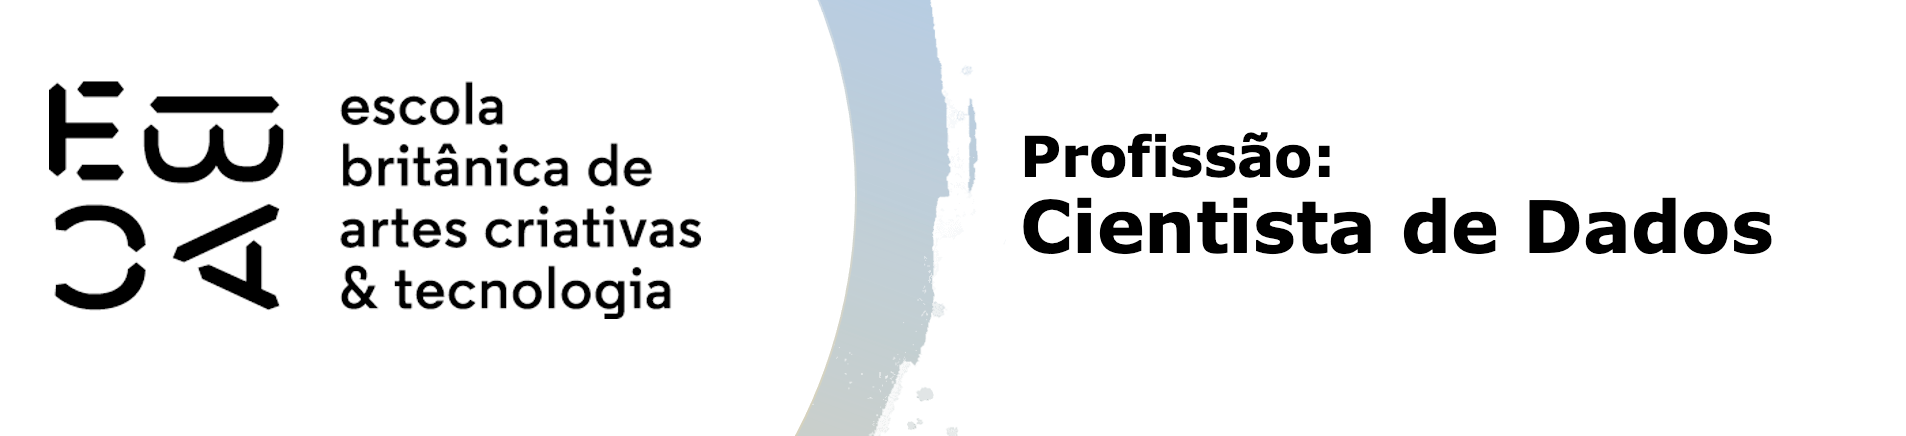

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
#pip install gower

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from gower import gower_matrix
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [6]:
# Separando as variáveis do escopo
df_escopo = df.iloc[:, [0,1,2,3,4,5,9,10,16]]

# Verificando a distribuição das variáveis
print(df_escopo.info())
df_escopo.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Month                    12330 non-null  object 
 8   Weekend                  12330 non-null  bool   
dtypes: bool(1), float64(4), int64(3), object(1)
memory usage: 782.8+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Administrative,12330.0,NaN,NaN,NaN,2.315166,3.321784,0.0,0.0,1.0,4.0,27.0
Administrative_Duration,12330.0,NaN,NaN,NaN,80.818611,176.779107,0.0,0.0,7.5,93.25625,3398.75
Informational,12330.0,NaN,NaN,NaN,0.503569,1.270156,0.0,0.0,0.0,0.0,24.0
Informational_Duration,12330.0,NaN,NaN,NaN,34.472398,140.749294,0.0,0.0,0.0,0.0,2549.375
ProductRelated,12330.0,NaN,NaN,NaN,31.731468,44.475503,0.0,7.0,18.0,38.0,705.0
ProductRelated_Duration,12330.0,NaN,NaN,NaN,1194.74622,1913.669288,0.0,184.1375,598.936905,1464.157214,63973.52223
SpecialDay,12330.0,NaN,NaN,NaN,0.061427,0.198917,0.0,0.0,0.0,0.0,1.0
Month,12330,10,May,3364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekend,12330,2,False,9462,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Verificando valores missing
df_escopo.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
SpecialDay                 0
Month                      0
Weekend                    0
dtype: int64

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [8]:
# Selecionando as variáveis relevantes para o agrupamento
var = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
             'SpecialDay', 'Month', 'Weekend']
var_qtd = ['Administrative', 'Administrative_Duration', 'Informational', 
             'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']
var_cat = ['SpecialDay', 'Month', 'Weekend']

# Padronizando as variáveis quantitativas
df_pad = pd.DataFrame(StandardScaler().fit_transform(df[var_qtd]), columns = df[var_qtd].columns)
df_pad.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348


In [9]:
df_pad[var_cat] = df[var_cat]

# Transformando variáveis qualitativas em variáveis dummy
df2 = pd.get_dummies(df_pad[var].dropna(), columns=var_cat)
df2

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,SpecialDay_0.0,SpecialDay_0.2,SpecialDay_0.4,SpecialDay_0.6,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Weekend_False,Weekend_True
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [10]:
vars_cat = [True if x in {'SpecialDay_0.0', 'SpecialDay_0.2',
       'SpecialDay_0.4', 'SpecialDay_0.6', 'SpecialDay_0.8',
       'SpecialDay_1.0', 'Month_Aug', 'Month_Dec', 'Month_Feb',
       'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May', 'Month_Nov',
       'Month_Oct', 'Month_Sep', 'Weekend_False', 'Weekend_True'} else False for x in df2.columns]

In [11]:
# Calculando a matriz de distância Gower
gower_dist = gower_matrix(df2, cat_features=vars_cat)

# Convertendo a matriz de distâncias em um vetor
gdv = squareform(gower_dist, force='tovector')

# Realizando a clusterização hierárquica com 3 grupos
Z = linkage(gdv, method='complete')
df_pad['Grupos_3'] = fcluster(Z, 3, criterion='maxclust')

# Realizando a clusterização hierárquica com 4 grupos
df_pad['Grupos_4'] = fcluster(Z, t=4, criterion='maxclust')

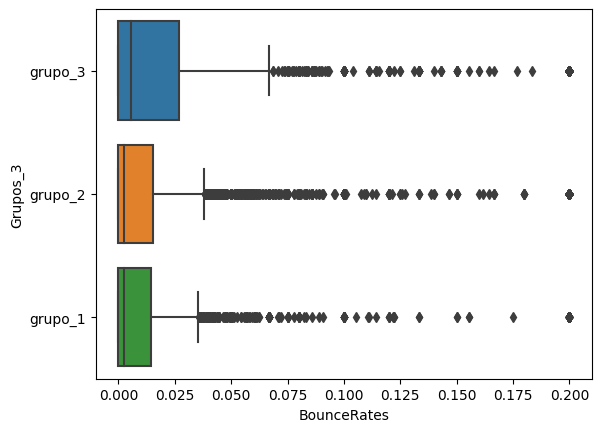

In [12]:
# Criando um novo DataFrame com as colunas de grupos usando join
df3 = df.join(df_pad[['Grupos_3', 'Grupos_4']], how='left')

# Substituindo os valores nos grupos do novo DataFrame
df3['Grupos_3'].replace({1: "grupo_1", 3: "grupo_3", 2: "grupo_2"}, inplace=True)
df3['Grupos_4'].replace({1: "grupo_1", 3: "grupo_3", 2: "grupo_2", 4: "grupo_4"}, inplace=True)

# Plotando boxplot para 3 grupos
sns.boxplot(data=df3, y='Grupos_3', x='BounceRates');

In [13]:
# Tabela de contingência para 3 grupos e Revenue
pd.crosstab(df3.Revenue, df3.Grupos_3)

Grupos_3,grupo_1,grupo_2,grupo_3
Revenue,,,
False,2342,5516,2564
True,498,1141,269


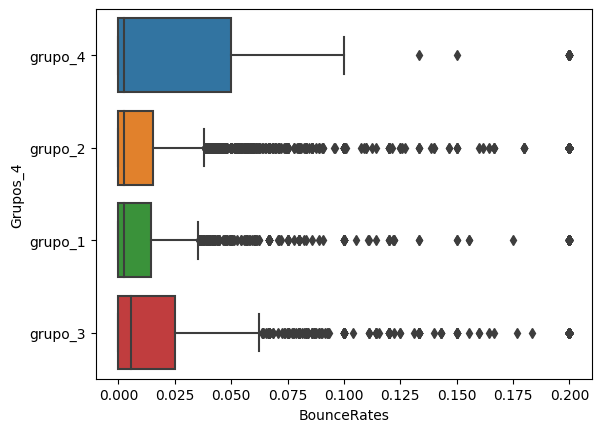

In [14]:
# Plotando boxplot para 4 grupos
sns.boxplot(data=df3, y='Grupos_4', x='BounceRates');

In [15]:
# Tabela de contingência para 4 grupos e Revenue
pd.crosstab(df3.Revenue, df3.Grupos_4)

Grupos_4,grupo_1,grupo_2,grupo_3,grupo_4
Revenue,,,,
False,2342,5516,2383,181
True,498,1141,266,3


## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [19]:
# Realizando a clusterização hierárquica com 2 grupos
df_pad['Grupos_2'] = fcluster(Z, 2, criterion='maxclust')

# Realizando a clusterização hierárquica com 6 grupos
df_pad['Grupos_6'] = fcluster(Z, t=6, criterion='maxclust')

df_pad.Grupos_2.value_counts()

2    9490
1    2840
Name: Grupos_2, dtype: int64

In [20]:
df_pad.Grupos_6.value_counts()

4    6655
1    2839
5    2649
6     184
3       2
2       1
Name: Grupos_6, dtype: int64

In [23]:
# Adicionando ao novo DataFrame as colunas de 2 e 6  grupos usando join
df3 = df.join(df_pad[['Grupos_2', 'Grupos_6']], how='left')

# Substituindo os valores nos grupos do novo DataFrame
df3['Grupos_6'].replace({1: "grupo_1", 3: "grupo_3", 2: "grupo_2", 4:"grupo_4", 5:"grupo_5", 6:"grupo_6"}, inplace=True)
df3['Grupos_2'].replace({1:"grupo_1", 2:"grupo_2"}, inplace=True)

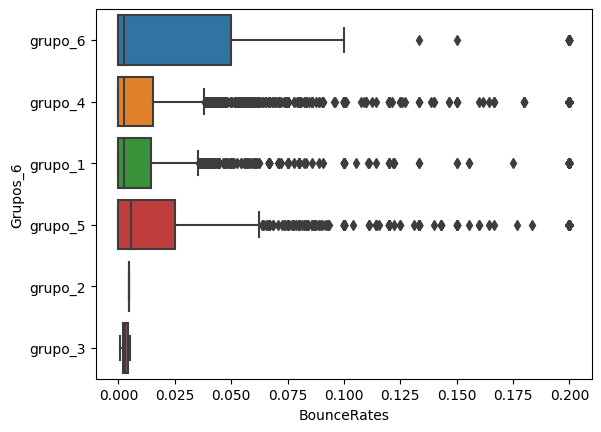

In [18]:
# Plotando boxplot para 6 grupos
sns.boxplot(data=df3, y='Grupos_6', x='BounceRates');

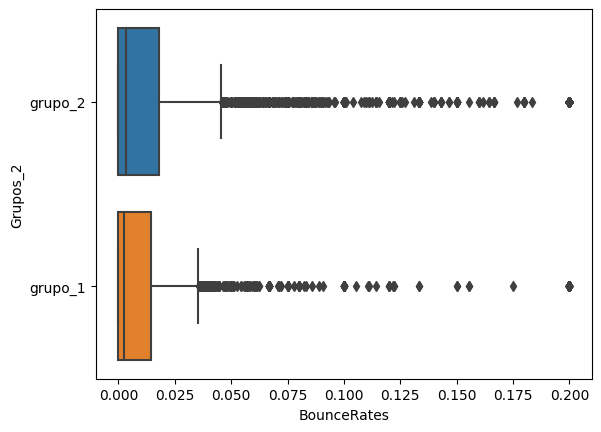

In [24]:
# Plotando boxplot para 2 grupos
sns.boxplot(data=df3, y='Grupos_2', x='BounceRates');

In [26]:
# Tabela de contingência para 2 grupos e Revenue
pd.crosstab(df3.Revenue, df3.Grupos_2)

Grupos_2,grupo_1,grupo_2
Revenue,,
False,2342,8080
True,498,1410


In [27]:
# Tabela de contingência para 6 grupos e Revenue
pd.crosstab(df3.Revenue, df3.Grupos_6)

Grupos_6,grupo_1,grupo_2,grupo_3,grupo_4,grupo_5,grupo_6
Revenue,,,,,,
False,2341,1,2,5514,2383,181
True,498,0,0,1141,266,3


<span style="color: darkolivegreen;"> Agora temos uma compreensão clara da forma como os grupos foram delineados. Essencialmente, a distinção principal parece estar relacionada à variável de final de semana, permitindo até mesmo a renomeação dos grupos para "Fim de Semana" e "Não Fim de Semana", caso seja desejado.</span>

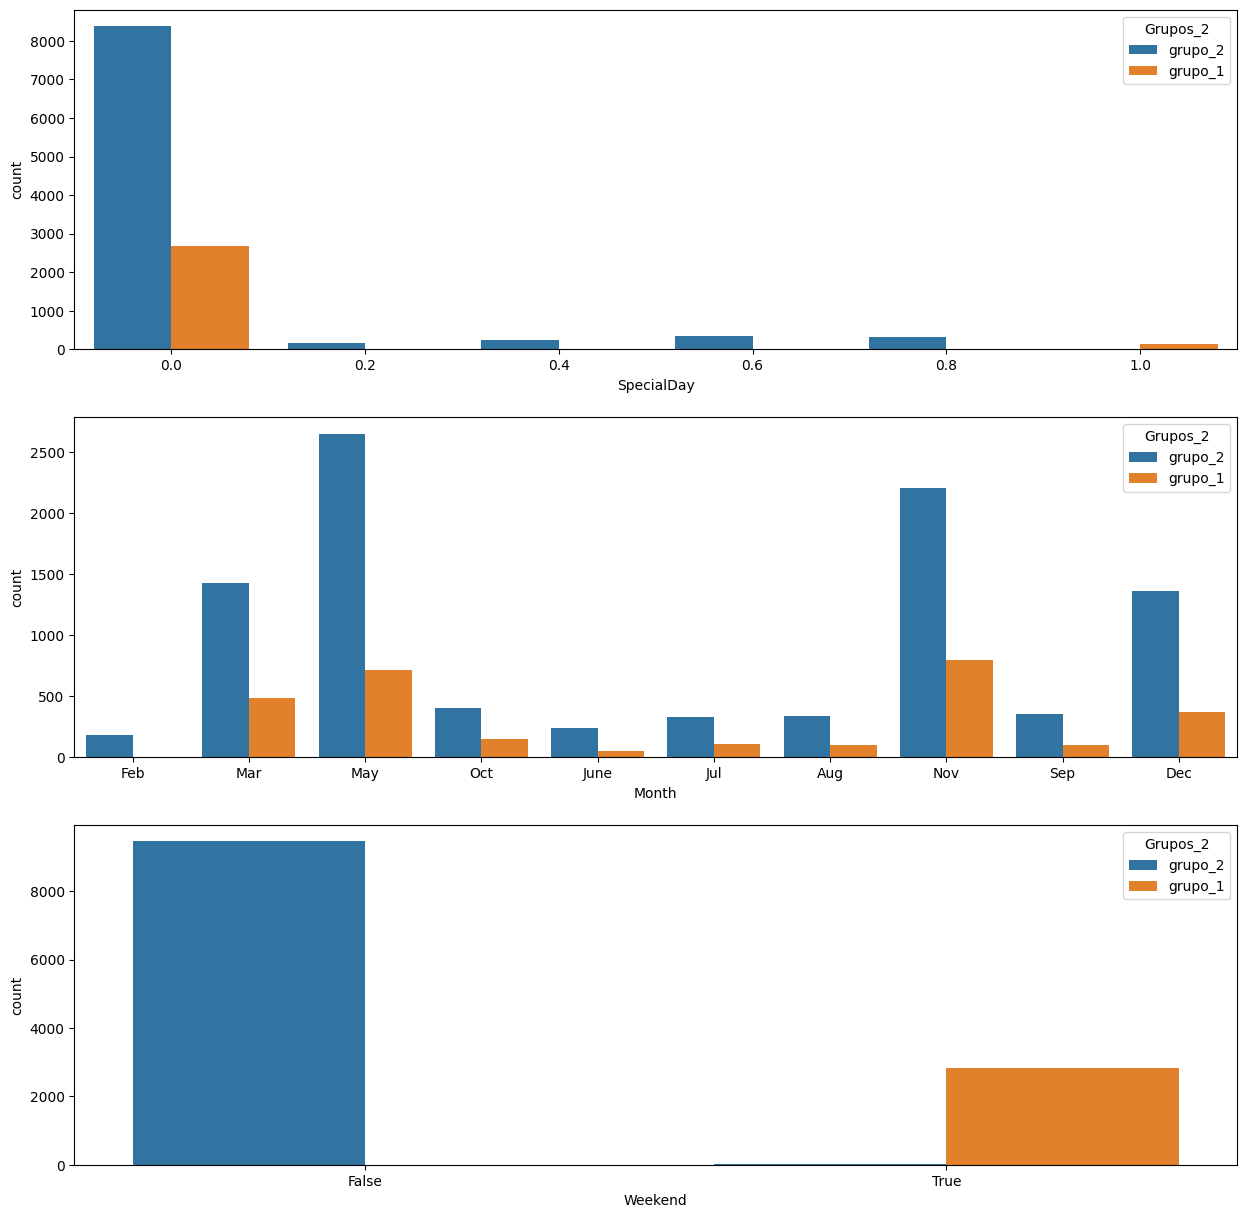

In [32]:
df2['Grupos_2'] = fcluster(Z, 2, criterion='maxclust')
df3 = df.join(df2['Grupos_2'], how='left')
df3['Grupos_2'].replace({1:"grupo_1", 2:"grupo_2"}, inplace=True)

fig, axis = plt.subplots(3, 1, figsize=(15,15))

sns.countplot(data=df3, x = "SpecialDay", hue='Grupos_2', ax=axis[0])

sns.countplot(data=df3, x = "Month", hue='Grupos_2', ax=axis[1])

sns.countplot(data=df3, x = "Weekend", hue='Grupos_2', ax=axis[2]);

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

<span style= "color: darkolivegreen;">Na avaliação com 2 grupos, constatou-se que o grupo identificado como "grupo_1" possui uma tendência maior a realizar compras (revenue = True), além de apresentar níveis mais baixos de Bounce Rate. Isso sugere que esse grupo é composto por clientes que demonstraram engajamento, especialmente nos finais de semana. Essa tendência foi corroborada quando expandimos a análise para 3 grupos, revelando que clientes que acessaram o site durante os finais de semana também tendem a ter maior propensão à compra.</span>